## Download the images


We can use **GoogleDriveDownloader** form **google_drive_downloader** library in Python to download the shared files from the shared Google drive link: https://drive.google.com/file/d/1f7uslI-ZHidriQFZR966_aILjlkgDN76/view?usp=sharing

The file id in the above link is: **1f7uslI-ZHidriQFZR966_aILjlkgDN76**

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1f7uslI-ZHidriQFZR966_aILjlkgDN76',
                                    dest_path='content/eye_gender_data.zip',
                                    unzip=True)

Unzipping...

/usr/local/lib/python3.7/dist-packages/google_drive_downloader/google_drive_downloader.py:78: UserWarning: Ignoring `unzip` since "1f7uslI-ZHidriQFZR966_aILjlkgDN76" does not look like a valid zip file
  warnings.warn('Ignoring `unzip` since "{}" does not look like a valid zip file'.format(file_id))


In [ ]:
!unzip ./eye_gender_data

We have all the files from the shared Google drive link downloaded in the colab environment.

## Loading Libraries
All Python capabilities are not loaded to our working environment by default (even they are already installed in your system). So, we import each and every library that we want to use.

We chose alias names for our libraries for the sake of our convenience (numpy --> np and pandas --> pd, tensorlow --> tf).

Note: You can import all the libraries that you think will be required or can import it as you go along.

In [4]:
import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf                                 # Deep Learning Tool
import os                                               # OS module in Python provides a way of using operating system dependent functionality
import cv2                                              # Library for image processing
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


%matplotlib inline

## Loading and preparing training data


In [5]:
labels = pd.read_csv("./eye_gender_data/Training_set.csv")   # loading the labels
file_paths = [[fname, './eye_gender_data/train/' + fname] for fname in labels['filename']]
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')

data = []     # initialize an empty numpy array
image_size = 100      # image size taken is 100 here. one can take other size too
for i in range(len(train_data)):
  
  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)   # converting the image to gray scale

  new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
  data.append([new_img_array, train_data['label'][i]])

In [6]:
# generate img dataset
img_data = []     # initialize an empty numpy array
image_size = 100      # image size taken is 100 here. one can take other size too
for i in range(len(train_data)):
  # load image
  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)
  new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
  img_data.append(new_img_array[:,:,np.newaxis])


In [7]:
img_tensor = tf.convert_to_tensor(np.asarray(img_data)/255)
img_tensor.shape

TensorShape([9220, 100, 100, 1])

In [8]:
# generate image tensor dataset
image_tf = tf.data.Dataset.from_tensor_slices(tf.cast(img_data, tf.float32))


In [9]:
# convert data to pandas dataframe
training_set = pd.DataFrame(data,columns=['image','label'])
training_set.head()

,image,label
0,"[[188, 188, 189, 189, 190, 186, 180, 182, 185,...",male
1,"[[167, 169, 173, 177, 181, 179, 178, 175, 175,...",female
2,"[[181, 179, 177, 176, 175, 175, 175, 175, 173,...",female
3,"[[98, 97, 97, 97, 98, 104, 108, 110, 111, 112,...",female
4,"[[177, 180, 180, 173, 174, 172, 168, 171, 170,...",male


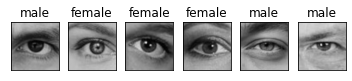

In [10]:
# check some example images
fig, axs = plt.subplots(1,6)
for i in range(6):
  axs[i].set_title(data[i][1])
  axs[i].imshow(cv2.cvtColor(data[i][0], cv2.COLOR_GRAY2RGB))
  axs[i].set_xticks([])
  axs[i].set_yticks([])

In [11]:
# check data statistics
num_train = len(data)
num_train_male = len(train_data[train_data['label']=='male'])
num_train_female = len(train_data[train_data['label']=='female'])

print('male image number : {}; percentage: {}'.format(num_train_male, num_train_male/num_train))
print('female image number : {}; percentage: {}'.format(num_train_female, num_train_female/num_train))

male image number : 5058; percentage: 0.548590021691974
female image number : 4162; percentage: 0.45140997830802604


## Data Pre-processing
It is necessary to bring all the images in the same shape and size, also convert them to their pixel values because all machine learning or deep learning models accepts only the numerical data. Also we need to convert all the labels from categorical to numerical values.

In [12]:
# convert labels to numerical data 0 and 1
# for female and male respectively
training_set.replace('male',1,inplace=True)
training_set.replace('female',0,inplace=True)

# make label as categorical value
training_set['label'] = pd.Categorical(training_set['label'])
training_set.head(5)

/usr/local/lib/python3.7/dist-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


,image,label
0,"[[188, 188, 189, 189, 190, 186, 180, 182, 185,...",1
1,"[[167, 169, 173, 177, 181, 179, 178, 175, 175,...",0
2,"[[181, 179, 177, 176, 175, 175, 175, 175, 173,...",0
3,"[[98, 97, 97, 97, 98, 104, 108, 110, 111, 112,...",0
4,"[[177, 180, 180, 173, 174, 172, 168, 171, 170,...",1


In [13]:
# convert to tensor
label_tensor = tf.convert_to_tensor(training_set['label'])
label_tensor

<tf.Tensor: shape=(9220,), dtype=int64, numpy=array([1, 0, 0, ..., 1, 1, 0])>

In [14]:
# convert labels to a tensor ds
label_tf = tf.data.Dataset.from_tensor_slices(tf.cast(training_set['label'], tf.int64))

In [15]:
# pack image and label as one tensor
image_label_ds = tf.data.Dataset.zip((image_tf, label_tf))
print(image_label_ds)

<ZipDataset element_spec=(TensorSpec(shape=(100, 100, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [16]:
# create image pipline for each set
batch_size = 32 

def format_image(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255
  return image, label

training_batches = image_label_ds.shuffle(num_train//4).map(format_image)

In [17]:
for image, label in enumerate(image_label_ds.take(3)):
    print('Image {} shape: {} label: {}'.format(image+1, label[0].shape, label[1]))

Image 1 shape: (100, 100, 1) label: 1
Image 2 shape: (100, 100, 1) label: 0
Image 3 shape: (100, 100, 1) label: 0


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# data augmentation
train_datagen = ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

## Building Model & Hyperparameter tuning
Now we are finally ready, and we can train the model.


In [19]:
# define input size
input_size = (100,100,1)

# define sequential model
model = tf.keras.models.Sequential()

# add Conv-pool layer1
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1),  
                                 activation='relu', padding='same', input_shape=input_size)) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# add Conv-pool layer2
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1),  
                                 activation='relu', padding='same', input_shape=input_size)) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add Conv-pool layer3
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1),  
                                 activation='relu', padding='same', input_shape=input_size)) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# add flatten layer 
model.add(tf.keras.layers.Flatten())  
# add dense layers with some dropout 
model.add(tf.keras.layers.Dense(256, activation='relu')) 
model.add(tf.keras.layers.Dropout(rate=0.3)) 
model.add(tf.keras.layers.Dense(256, activation='relu')) 
model.add(tf.keras.layers.Dropout(rate=0.3))  
# add output layer 
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# compile model 
model.compile(optimizer='adam',  
              loss='binary_crossentropy',  
              metrics=['accuracy'])  
# view model layers 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

In [20]:
# model training

EPOCHS = 100 
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2,  
                                               restore_best_weights=True, verbose=1)  
history = model.fit(img_tensor, label_tensor,
                    batch_size=32, 
                    callbacks=[es_callback],  
                    validation_split=0.1, 
                    epochs=EPOCHS, verbose=1)

Epoch 1/100
260/260 [==============================] - 18s 26ms/step - loss: 0.5353 - accuracy: 0.7205 - val_loss: 0.4782 - val_accuracy: 0.7755
Epoch 2/100
260/260 [==============================] - 6s 23ms/step - loss: 0.3718 - accuracy: 0.8401 - val_loss: 0.3149 - val_accuracy: 0.8731
Epoch 3/100
260/260 [==============================] - 6s 24ms/step - loss: 0.3039 - accuracy: 0.8729 - val_loss: 0.3089 - val_accuracy: 0.8829
Epoch 4/100
260/260 [==============================] - 6s 23ms/step - loss: 0.2671 - accuracy: 0.8933 - val_loss: 0.3357 - val_accuracy: 0.8482
Epoch 5/100
260/260 [==============================] - 6s 22ms/step - loss: 0.2306 - accuracy: 0.9074 - val_loss: 0.2609 - val_accuracy: 0.8785
Epoch 6/100
260/260 [==============================] - 6s 22ms/step - loss: 0.2065 - accuracy: 0.9168 - val_loss: 0.2680 - val_accuracy: 0.8861
Epoch 7/100
260/260 [==============================] - 6s 22ms/step - loss: 0.1853 - accuracy: 0.9246 - val_loss: 0.1999 - val_accuracy

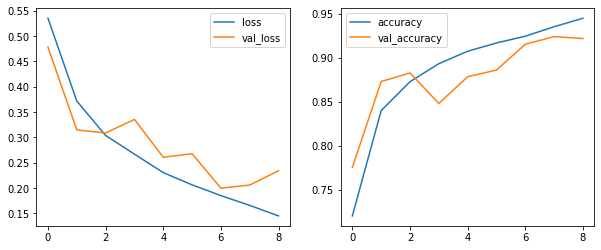

In [21]:
# plot learning curve
fig, ax = plt.subplots(1, 2, figsize=(10, 4))  
history_df = pd.DataFrame(history.history) 
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0]) 
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

## Fine-tuning a pre-trained VGG19 CNN model


In [31]:
# convert image to 3-channel image
train_images_3ch = np.stack([img_tensor]*3, axis=3)  
train_images_3ch = train_images_3ch.squeeze()
print('\nTrain_images.shape: {}, of {}'.format(train_images_3ch.shape, train_images_3ch.dtype)) 


Train_images.shape: (9220, 100, 100, 3), of float64


In [32]:
# Build Cut-VGG19 Model
# define input shape 
INPUT_SHAPE = (image_size, image_size, 3)  
# get the VGG19 model 
vgg_layers = tf.keras.applications.vgg19.VGG19(weights='imagenet', 
                                               include_top=False,  
                                               input_shape=INPUT_SHAPE)  
vgg_layers.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                              

In [33]:
# Set layers to trainable to enable fine-tuning
# Fine-tune all the layers 
for layer in vgg_layers.layers: 
  layer.trainable = True  
# Check the trainable status of the individual layers 
for layer in vgg_layers.layers: 
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f7bf7fbf1d0> True
<keras.layers.convolutional.Conv2D object at 0x7f7c72b9e310> True
<keras.layers.convolutional.Conv2D object at 0x7f7c72ddffd0> True
<keras.layers.pooling.MaxPooling2D object at 0x7f7c72e68150> True
<keras.layers.convolutional.Conv2D object at 0x7f7c72e74ed0> True
<keras.layers.convolutional.Conv2D object at 0x7f7c72b79e50> True
<keras.layers.pooling.MaxPooling2D object at 0x7f7bf7767cd0> True
<keras.layers.convolutional.Conv2D object at 0x7f7bf8026f10> True
<keras.layers.convolutional.Conv2D object at 0x7f7bf8026390> True
<keras.layers.convolutional.Conv2D object at 0x7f7bf8026550> True
<keras.layers.convolutional.Conv2D object at 0x7f7b827db550> True
<keras.layers.pooling.MaxPooling2D object at 0x7f7b827db2d0> True
<keras.layers.convolutional.Conv2D object at 0x7f7c72f16750> True
<keras.layers.convolutional.Conv2D object at 0x7f7c72f26910> True
<keras.layers.convolutional.Conv2D object at 0x7f7b8381cdd0> True
<keras.l

### Build CNN model on top of VGG19

In [34]:
# define sequential model 
model_vgg = tf.keras.models.Sequential()  
# Add the vgg convolutional base model 
model_vgg.add(vgg_layers)  
# add flatten layer 
model_vgg.add(tf.keras.layers.Flatten())  
# add dense layers with some dropout 
model_vgg.add(tf.keras.layers.Dense(256, activation='relu')) 
model_vgg.add(tf.keras.layers.Dropout(rate=0.3)) 
model_vgg.add(tf.keras.layers.Dense(256, activation='relu')) 
model_vgg.add(tf.keras.layers.Dropout(rate=0.3))  
# add output layer 
model_vgg.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

# compile model 
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),  
                  loss='binary_crossentropy',  
                  metrics=['accuracy'])  
# view model layers 
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [35]:
EPOCHS = 100 
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=2,  
                                               restore_best_weights=True, 
                                               verbose=1)  
history = model_vgg.fit(train_images_3ch, label_tensor, 
                    batch_size=32, 
                    callbacks=[es_callback],  
                    validation_split=0.1, 
                    epochs=EPOCHS, 
                    verbose=1)

Epoch 1/100
260/260 [==============================] - 100s 368ms/step - loss: 0.2786 - accuracy: 0.8815 - val_loss: 0.1250 - val_accuracy: 0.9534
Epoch 2/100
260/260 [==============================] - 93s 356ms/step - loss: 0.1404 - accuracy: 0.9456 - val_loss: 0.1178 - val_accuracy: 0.9523
Epoch 3/100
260/260 [==============================] - 92s 356ms/step - loss: 0.1109 - accuracy: 0.9566 - val_loss: 0.1092 - val_accuracy: 0.9620
Epoch 4/100
260/260 [==============================] - 92s 356ms/step - loss: 0.0833 - accuracy: 0.9681 - val_loss: 0.1038 - val_accuracy: 0.9577
Epoch 5/100
260/260 [==============================] - 92s 355ms/step - loss: 0.0677 - accuracy: 0.9736 - val_loss: 0.1058 - val_accuracy: 0.9642
Epoch 6/100
260/260 [==============================] - 92s 355ms/step - loss: 0.0531 - accuracy: 0.9806 - val_loss: 0.1254 - val_accuracy: 0.9512
Epoch 6: early stopping


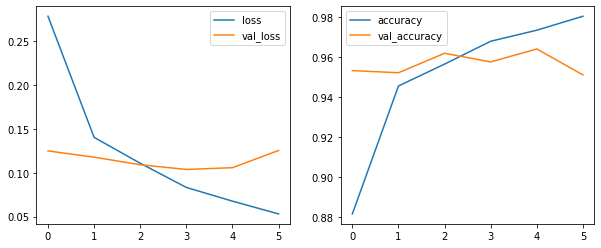

In [36]:
# plot learning curves
fig, ax = plt.subplots(1, 2, figsize=(10, 4))  
history_df = pd.DataFrame(history.history) 
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0]) 
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1]);

## Predict The Output For Testing Dataset 😅
We have trained our model, evaluated it and now finally we will predict the output/target for the testing data (i.e. Test.csv).

#### Load Test Set
Load the test data on which final submission is to be made.

In [22]:
file_name = pd.read_csv("./eye_gender_data/Testing_set.csv")   # loading the labels
file_paths = [[fname, './eye_gender_data/test/' + fname] for fname in file_name['filename']]
test_data = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])

# generate img dataset
img_data = []     # initialize an empty numpy array
image_size = 100      # image size taken is 100 here. one can take other size too
for i in range(len(test_data)):
  # load image
  img_array = cv2.imread(test_data['filepaths'][i], cv2.IMREAD_GRAYSCALE)
  new_img_array = cv2.resize(img_array, (image_size, image_size))      # resizing the image array
  img_data.append(new_img_array[:,:,np.newaxis])

# normalise to between 0 and 1, convert to tensor
test_tensor = tf.convert_to_tensor(np.asarray(img_data)/255)
test_tensor.shape

TensorShape([2305, 100, 100, 1])

## Data Pre-processing on test_data


In [37]:
# convert image to 3-channel image
test_images_3ch = np.stack([test_tensor]*3, axis=3)  
test_images_3ch = test_images_3ch.squeeze()
print('\nTrain_images.shape: {}, of {}'.format(test_images_3ch.shape, test_images_3ch.dtype)) 


Train_images.shape: (2305, 100, 100, 3), of float64


### Make Prediction on Test Dataset
Time to make a submission!!!

In [23]:
predictions = model.predict(test_tensor)

In [24]:
predictions_label = np.squeeze((predictions >= 0.5)*1)
predictions_label=np.where(predictions_label == 1,'male','female')
predictions_label[:5]

array(['male', 'male', 'male', 'male', 'male'], dtype='<U6')

In [38]:
predictions_vgg = model_vgg.predict(test_images_3ch)

In [39]:
predictions_label_vgg = np.squeeze((predictions_vgg >= 0.5)*1)
predictions_label_vgg = np.where(predictions_label_vgg == 1,'male','female')
predictions_label_vgg[:5]

array(['male', 'male', 'male', 'male', 'male'], dtype='<U6')

## **How to save prediciton results locally via jupyter notebook?**
If you are working on Jupyter notebook, execute below block of codes. A file named 'submission.csv' will be created in your current working directory.

In [ ]:
res = pd.DataFrame({'filename': test_data['filename'], 'label': predictions})  # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res.to_csv("submission.csv", index = False)      # the csv file will be saved locally on the same location where this notebook is located.

# **OR,**
**If you are working on Google Colab then use the below set of code to save prediction results locally**

## **How to save prediction results locally via colab notebook?**
If you are working on Google Colab Notebook, execute below block of codes. A file named 'prediction_results' will be downloaded in your system.

In [40]:
res = pd.DataFrame({'filename': test_data['filename'], 'label': predictions_label})  # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res.to_csv("submission.csv", index = False) 

res_vgg = pd.DataFrame({'filename': test_data['filename'], 'label': predictions_label_vgg})  # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res_vgg.to_csv("submission_vgg.csv", index = False) 

In [41]:
# To download the csv file locally
from google.colab import files        
files.download('submission.csv')
files.download('submission_vgg.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Well Done! 👍**
You are all set to make a submission. Let's head to the **[challenge page](https://dphi.tech/challenges/4-week-deep-learning-online-bootcamp-final-assignment-sex-determination-by-morphometry-of-eyes/144/submit)** to make the submission.